In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sktime.transformations.compose import ColumnwiseTransformer
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.base import BaseTransformer

from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.transformations.compose import FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures

from catboost import CatBoostRegressor
import shap as sp

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv('daily-website-visitors.csv')[["Date", "Page.Loads", "Unique.Visits", "First.Time.Visits", "Returning.Visits"]]
df = df.rename(columns={"Date": 'ds', 
                        "Page.Loads": 'y1',
                        "Unique.Visits": 'y2',
                        "First.Time.Visits": 'y3',
                        "Returning.Visits": 'y4'
                       })

In [4]:
targets = ['y1', 'y2', 'y3', 'y4']

In [5]:
df['ds'] = pd.to_datetime(df.ds, yearfirst = True)

for target in targets : 
    df[target] = df[target].str.replace(',','.').astype("float")

df = df.set_index('ds')

In [6]:
y_train, y_test = temporal_train_test_split(df, test_size=365)
index_train, index_test = y_train.index, y_test.index

In [7]:
class ZScoreTransformer(BaseTransformer):
    def __init__(self, window=30):
        self.window = window
        super(ZScoreTransformer, self).__init__()

    def transform(self, Z, X=None):
        z = Z.to_frame('y')
        z_score = (z['y'] - z['y'].rolling(window=self.window).mean()) / z['y'].rolling(window=self.window).std()
        z.loc[np.abs(z_score) > 3, 'y'] = np.nan
        return z

def inverse_transform(pipeline, X_transformed):
    # Iterate over the steps in reverse order
    for name, transformer in reversed(pipeline.steps):
        if hasattr(transformer, 'inverse_transform') & (name not in ['z_score']):
            X_transformed = transformer.inverse_transform(X_transformed)
    return X_transformed

In [8]:
transform = Pipeline(
    steps=[
        ("log", ColumnwiseTransformer(LogTransformer(offset=1))),
        #("differencer", ColumnwiseTransformer(Differencer(lags=1))),
        #("z_score", ColumnwiseTransformer(ZScoreTransformer(window=30))),
        #("imputer", ColumnwiseTransformer(Imputer(method="drift"))),
        ("scale", ColumnwiseTransformer(TabularToSeriesAdaptor(StandardScaler()))),
    ]
)

window_summarizer = WindowSummarizer(
    lag_feature={
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
        "std": [[1, 7], [1, 28], [7,14], [15, 21], [22,28]],
    }
)

multi_window_summarizer = ColumnEnsembleTransformer(
    transformers = [(f'window_summarizer_{target}', window_summarizer, target) for target in targets]
)

fourier_featurizer = FourierFeatures(sp_list=[365.25, 7], fourier_terms_list=[10, 2], freq='D')

featurizer = FeatureUnion([multi_window_summarizer, fourier_featurizer])

In [9]:
y_train_transform = transform.fit_transform(y_train)
y_full_transform = y_train_transform.reindex(y_train_transform.index.union(y_test.index))
X_full = featurizer.fit_transform(y_full_transform)

In [10]:
lag_features = [f"ColumnEnsembleTransformer__{j}_lag_{i}" for i in window_summarizer.lag_feature["lag"] for j in targets]
mean_features = [f"ColumnEnsembleTransformer__{j}_mean_{start}_{end}" for start, end in window_summarizer.lag_feature["mean"] for j in targets]
std_features = [f"ColumnEnsembleTransformer__{j}_std_{start}_{end}" for start, end in window_summarizer.lag_feature["std"] for j in targets]
fourier_features = [f"FourierFeatures__{fn}_{per}_{i}" for per, freq in zip(fourier_featurizer.sp_list, fourier_featurizer.fourier_terms_list) for i in range(1, freq + 1) for fn in ("cos", "sin")]
to_update_features = lag_features + mean_features + std_features

In [11]:
X_full = X_full[lag_features + mean_features + std_features + fourier_features]
X_train, X_test = X_full.loc[index_train], X_full.loc[index_test]

In [12]:
models = {}
for target in targets:
    model = CatBoostRegressor(loss_function="RMSE", has_time=True)
    model.fit(X_train, y_train_transform[target], verbose=False)
    models[target] = model

In [13]:
for idx in index_test:
    y_tmp = y_full_transform.loc[idx-pd.DateOffset(28+1):idx]
    X_test.loc[idx, to_update_features] = featurizer.transform(y_tmp).loc[idx, to_update_features]
    for target in targets:
        y_full_transform.loc[idx, target] = models[target].predict(X_test.loc[idx])
    
y_pred = inverse_transform(transform, y_full_transform.loc[index_test])

MSE: 1.2027231339188238
MAPE: 0.2410535113847875


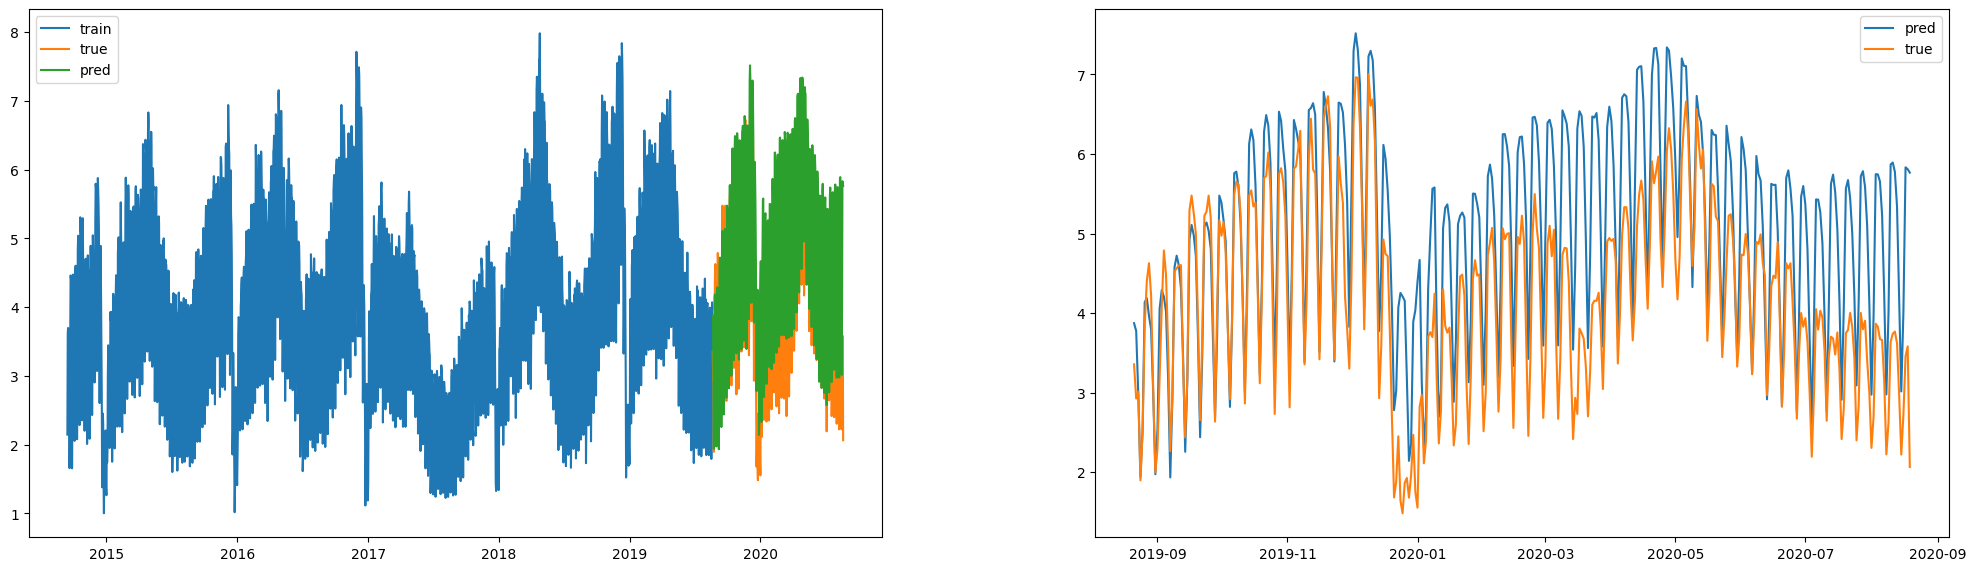

MSE: 0.44065115106555985
MAPE: 0.19379407591350697


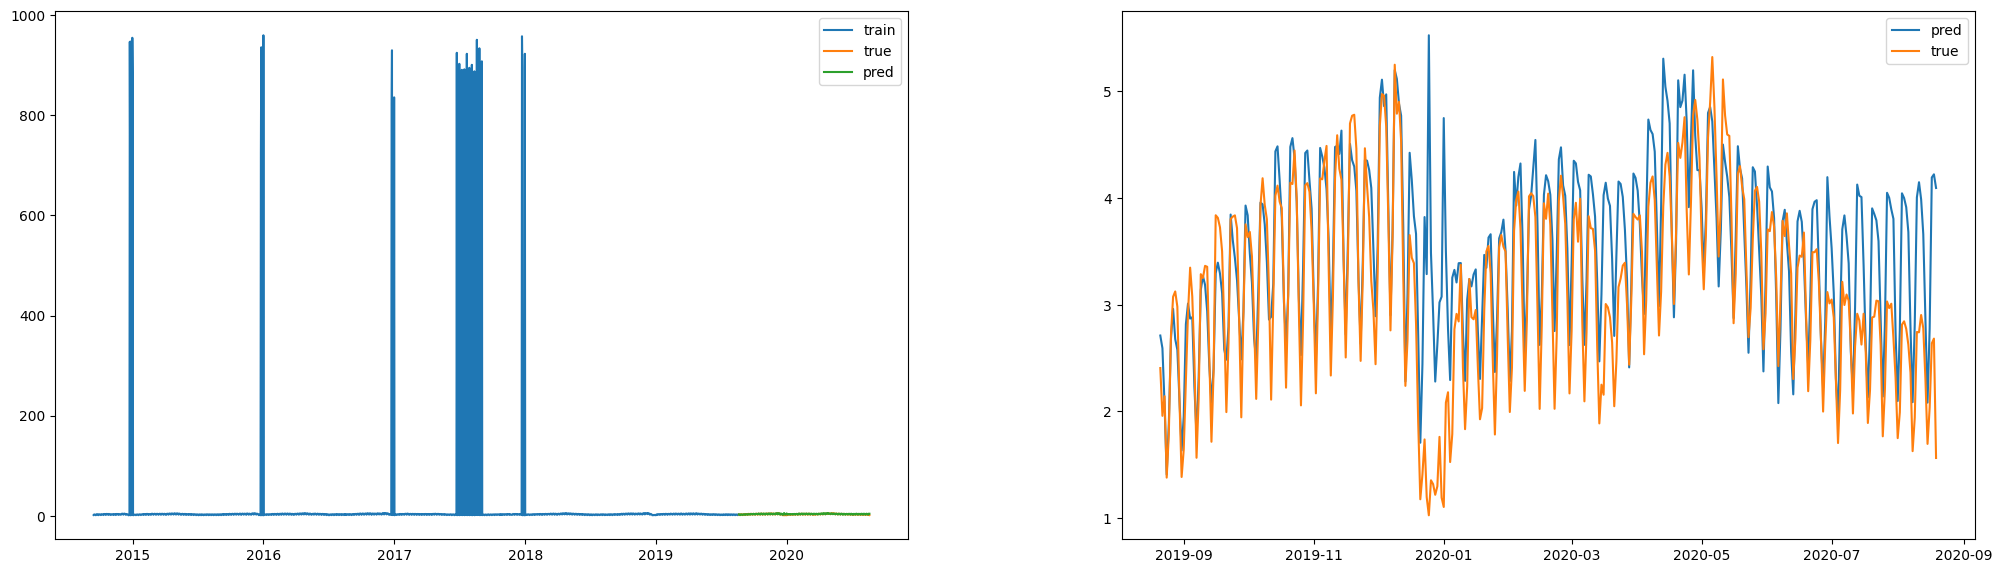

MSE: 6595.842667644129
MAPE: 0.2653316081771153


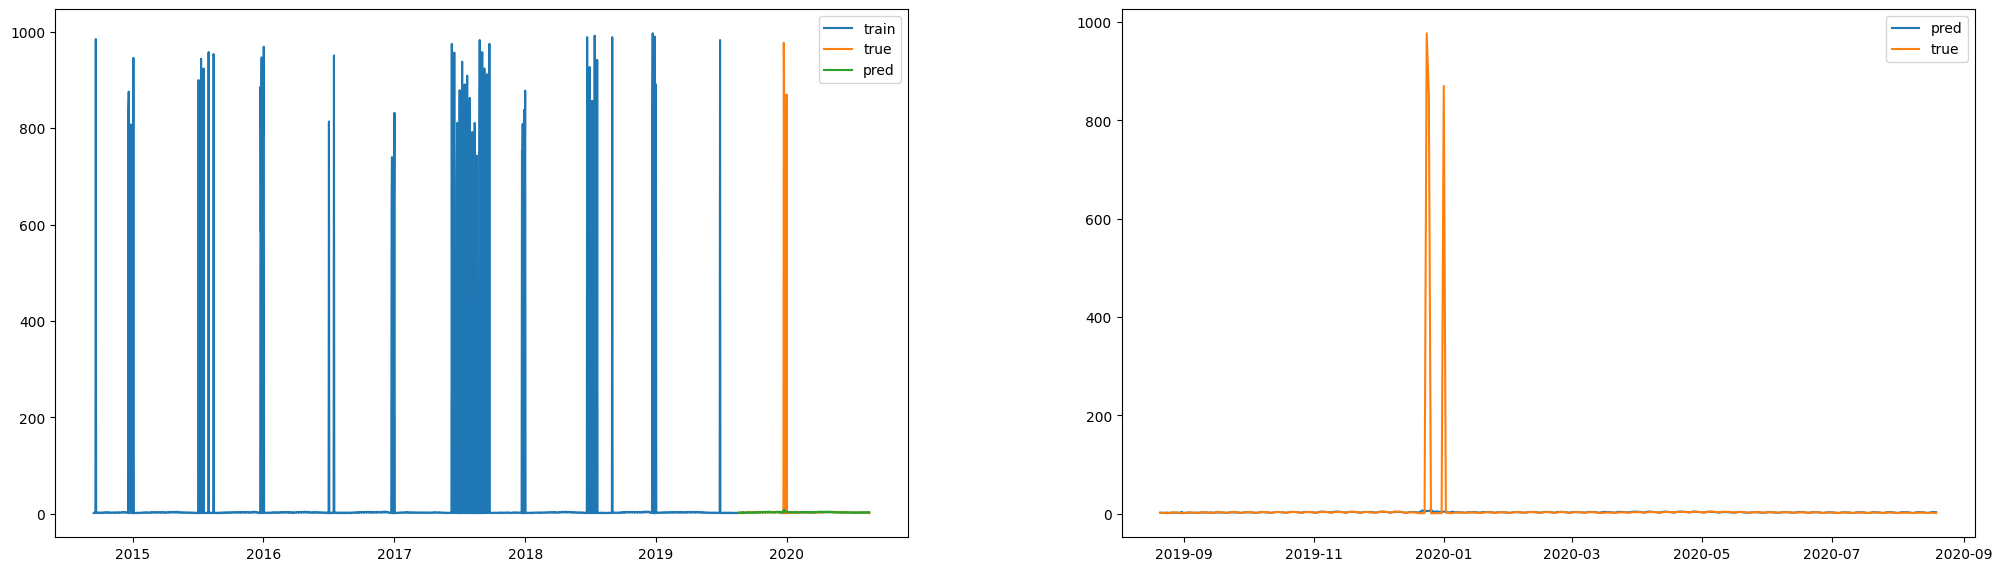

MSE: 5538.2855537700625
MAPE: 0.13328683345054093


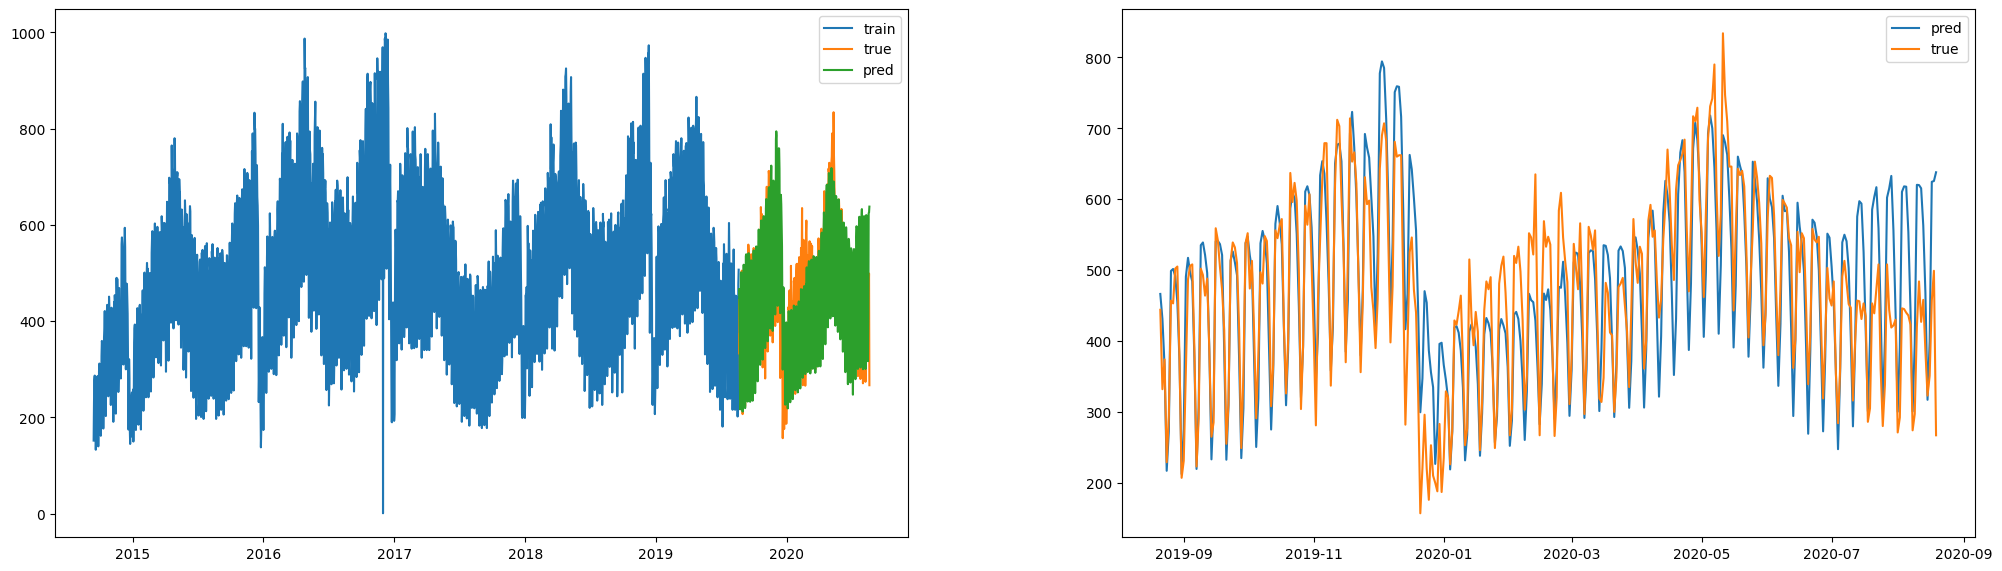

In [14]:
for target in targets:
    print("MSE:", mean_squared_error(y_test[target], y_pred[target]))
    print("MAPE:", mean_absolute_percentage_error(y_test[target], y_pred[target]))
    
    fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2)

    ax0.plot(y_train.index, y_train[target], label='train')
    ax0.plot(y_test.index, y_test[target], label='true')
    ax0.plot(y_pred.index, y_pred[target], label='pred')
    ax0.legend()

    ax1.plot(y_pred.index, y_pred[target], label='pred')
    ax1.plot(y_test.index, y_test[target], label='true')
    ax1.legend()

    plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
    plt.show()

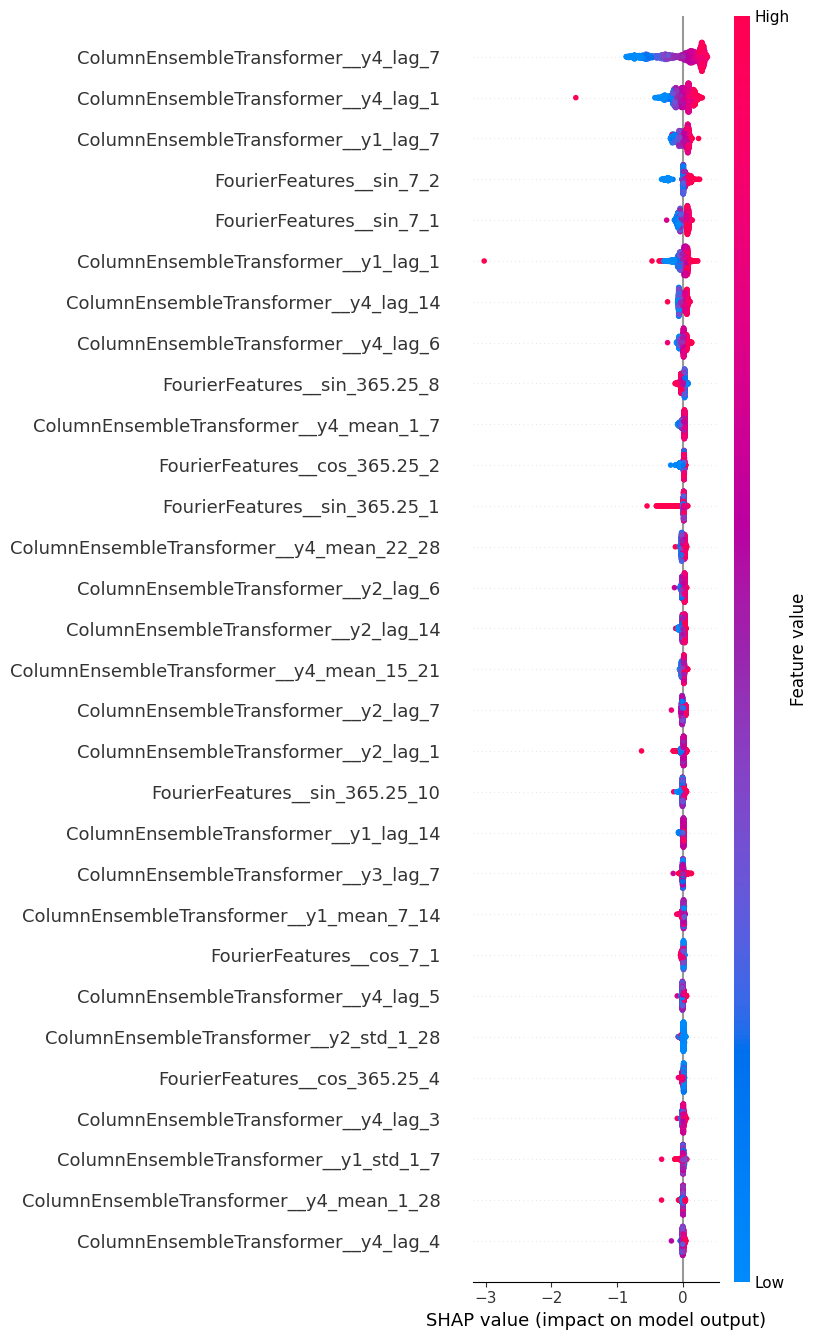

In [15]:
explainer = sp.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
 
sp.summary_plot(shap_values, X_train, max_display=30 )